<a href="https://colab.research.google.com/github/WPHdamian/Data-Science-Curriculum-Analysis-/blob/main/04_ESCO_Skill_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 4 - ESCO Skill Matching for Curriculum Analysis

This section operationalises the ESCO skills taxonomy to extract and analyse skill signals
from curriculum module texts. Using a dictionary-based matching approach, module-level
tokens (including unigrams, bigrams, and trigrams) are matched against ESCO skill labels
and their alternative labels.

ESCO is used as a **machine-readable operational taxonomy**, while higher-level
interpretation is handled later using the extended EDISON framework.

Outputs of this notebook include:
- ESCO skill matches per module
- Aggregated ESCO skill distributions by city
- Visual summaries of skill emphasis differences

All figures are saved to the `/Output/` directory.


## 4.1 Setup

In [197]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import defaultdict
from pathlib import Path

output_dir = Path("Output")
output_dir.mkdir(exist_ok=True)


## 4.2.1 Load Curriculum Dataset

The curriculum dataset has been preprocessed in Notebook 01 and stored as a parquet file.
This notebook uses the `clean_tokens` column, which contains unigrams, bigrams, and trigrams
representing cleaned module text.

In [199]:
df = pd.read_parquet("curriculum_with_topics.parquet")
# df = pd.read_parquet("data/curriculum_with_topics.parquet")
df.head()


,city,university,program_name,faculty,level,module_code,module_title,module_description,core_or_elective,module_id,...,clean_text_basic,clean_text_domain,clean_text_syn,entity_tokens,clean_text_entity,clean_tokens,clean_text_final,tokens_final,dominant_topic,topic_probability
0,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4301,Corporate Accounting II,This course aims to:\n\ndevelop students' conc...,Elective,cityu_corporate accounting ii_bachelor,...,corporate accounting ii course aim develop stu...,corporate accounting ii conceptual professiona...,corporate accounting ii conceptual professiona...,"[corporate, accounting, ii, conceptual, profes...",corporate accounting ii conceptual professiona...,"[corporate, accounting, ii, conceptual, profes...",corporate accounting ii conceptual professiona...,"[corporate, accounting, ii, conceptual, profes...",4,0.318844
1,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,AC4342,Auditing,The primary objective of this course is to pro...,Elective,cityu_auditing_bachelor,...,audit primary objective course provide student...,audit primary objective regulatory legal repor...,audit primary objective regulatory legal repor...,"[audit, primary_objective, regulatory, legal, ...",audit primary_objective regulatory legal repor...,"[audit, primary_objective, regulatory, legal, ...",audit primary_objective regulatory legal repor...,"[audit, primary_objective, regulatory, legal, ...",1,0.971788
2,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2100,Introduction to Financial Accounting,This course aims to:\n\nprovide students with ...,Core,cityu_introduction to financial accounting_bac...,...,introduction financial accounting course aim p...,financial accounting technical processing prep...,financial accounting technical processing prep...,"[financial_accounting, technical, processing, ...",financial_accounting technical processing prep...,"[financial_accounting, technical, processing, ...",financial_accounting technical processing prep...,"[financial_accounting, technical, processing, ...",4,0.635526
3,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2101,Introduction to Managerial Accounting,This course aims to: 1.provide students with b...,Core,cityu_introduction to managerial accounting_ba...,...,introduction managerial accounting course aim ...,managerial accounting management account caree...,managerial accounting management account caree...,"[managerial_accounting, management_account, ca...",managerial_accounting management_account caree...,"[managerial_accounting, management_account, ca...",managerial_accounting management_account caree...,"[managerial_accounting, management_account, ca...",1,0.977423
4,Hong Kong,City University of Hong Kong,Bsc In Business Decision Analytics,Department of Decision Analytics and Operations,Bachelor,CB2200,Business Statistics,This course aims to facilitate students' learn...,Core,cityu_business statistics_bachelor,...,business statistic course aim facilitate stude...,business statistic facilitate statistical comm...,business statistic facilitate statistical comm...,"[business, statistic, facilitate, statistical,...",business statistic facilitate statistical comm...,"[business, statistic, facilitate, statistical,...",business statistic facilitate statistical comm...,"[business, statistic, facilitate, statistical,...",4,0.723241


In [200]:
def expand_ngrams(tokens):
    """
    For each token in the list:
    - keep the original token
    - if token contains '_', split into unigrams and add to list
    - remove empty strings
    """
    expanded = set(tokens)  # start with original tokens
    for tok in tokens:
        if "_" in tok:
            parts = tok.split("_")
            expanded.update([p for p in parts if p.strip()])  # add non-empty unigrams
    return list(expanded)

# Apply to DataFrame
df["clean_tokens_expanded"] = df["clean_tokens"].apply(expand_ngrams)

## 4.2.2 Load ESCO Skills Taxonomy

The ESCO skills taxonomy provides a machine-readable list of skill concepts, including:
- preferred labels
- alternative labels (synonyms)
- skill types (technical, transversal, etc.)

This notebook uses `skills_en.csv` as the sole ESCO source.


In [201]:
esco = pd.read_csv("skills_en.csv")
#esco = pd.read_csv("data/skills_en.csv")
esco = esco[esco["status"] == "released"].copy()
esco.shape


(13960, 13)

## 4.3 ESCO Label Normalisation and Expansion

To maximise recall, both preferred labels and alternative labels are normalised and expanded.
Each label is mapped back to its ESCO `conceptUri`, enabling consistent identification across
modules.


In [202]:
def normalize(text):
    return re.sub(r"\s+", "_", text.lower().strip())


In [203]:
esco_label_map = defaultdict(list)

for _, row in esco.iterrows():
    labels = []
    if pd.notna(row["preferredLabel"]):
        labels.append(row["preferredLabel"])
    if pd.notna(row["altLabels"]):
        labels.extend(row["altLabels"].split("|"))

    for lab in labels:
        norm = normalize(lab)
        if norm:
            esco_label_map[norm].append({
                "preferredLabel": row["preferredLabel"],
                "skillType": row["skillType"],
                "conceptUri": row["conceptUri"]
            })


## 4.4 ESCO Skill Matching

Each module's `clean_tokens` are compared against the ESCO label dictionary.
Matches are recorded at the module level without inferring skill proficiency.


In [204]:
GENERIC_TERMS = {
    "management", "analysis", "system", "process", "business",
    "data", "model", "method", "technology", "application"
}

In [205]:
MAX_SKILLS_PER_MODULE = 50  # prevent overstacking or broken for loops


In [206]:
def match_esco_skills(token_list, esco_map):
    matched = set()

    for tok in token_list:
        tok = tok.lower()

        # Skip generic unigrams
        if "_" not in tok and tok in GENERIC_TERMS:
            continue

        # Exact match
        if tok in esco_map:
            matched.update(esco_map[tok])
            continue

        # Controlled head-noun fallback
        if "_" in tok:
            head = tok.split("_")[-1]
            if head not in GENERIC_TERMS and head in esco_map:
                matched.update(esco_map[head])

        # Threshold guard
        if len(matched) >= MAX_SKILLS_PER_MODULE:
            break

    return sorted(matched)


In [207]:
ESCO_BRIDGE = {
    "data_analytic": "perform data analysis",
    "statistical": "statistics",
    "big_data": "analyse big data",
    "machine":"machine learning",
    "data_mining":"perform data mining",
    "database_management":"database management systems"
}


In [208]:
def apply_esco_bridge(tokens, esco_map, bridge_dict):
    matched = set()

    for tok in tokens:
        tok_norm = tok.lower()

        # First try direct ESCO match
        if tok_norm in esco_map:
            matched.update(esco_map[tok_norm])

        # Then try bridge dictionary
        elif tok_norm in bridge_dict:
            bridge_label = normalize(bridge_dict[tok_norm])
            if bridge_label in esco_map:
                matched.update(esco_map[bridge_label])

    return sorted(matched)


In [209]:
def match_esco_with_types(tokens, esco_map, bridge_dict=None, max_skills=50):
    matched_labels = set()
    matched_types = set()

    for tok in tokens:
        tok_norm = tok.lower()

        # Exact match
        if tok_norm in esco_map:
            for entry in esco_map[tok_norm]:
                matched_labels.add(entry["preferredLabel"])
                matched_types.add(entry["skillType"])

        # Optional: bridge dictionary
        if bridge_dict and tok_norm in bridge_dict:
            bridge_label = bridge_dict[tok_norm].lower().replace(" ", "_")
            if bridge_label in esco_map:
                for entry in esco_map[bridge_label]:
                    matched_labels.add(entry["preferredLabel"])
                    matched_types.add(entry["skillType"])

        # Threshold guard
        if len(matched_labels) >= max_skills:
            break

    return sorted(matched_labels), sorted(matched_types)

In [210]:
df["esco_skills"], df["esco_skill_types"] = zip(*df["clean_tokens"].apply(
    lambda toks: match_esco_with_types(toks, esco_label_map, bridge_dict=ESCO_BRIDGE)
))

df["esco_skill_count"] = df["esco_skills"].apply(len)
df["esco_skill_type_count"] = df["esco_skill_types"].apply(len)


In [211]:
df[["clean_tokens_expanded","esco_skills","esco_skill_count","esco_skill_types","esco_skill_type_count"]].head()

,clean_tokens_expanded,esco_skills,esco_skill_count,esco_skill_types,esco_skill_type_count
0,"[financial, accounting_standard, information, ...",[accounting],1,[knowledge],1
1,"[identify, communication, written, ability, co...",[communication],1,[knowledge],1
2,"[financial, information, general, processing, ...",[accounting],1,[knowledge],1
3,"[identify, foundation, valuation, product, man...",[],0,[],0
4,"[management_decision_making, business, ability...",[statistics],1,[knowledge],1


In [212]:
len(df[df["esco_skill_count"]==0])/len(df["clean_tokens_expanded"])

0.3806818181818182

## 4.5 Aggregate ESCO Skill Signals by City

This section summarises ESCO skill occurrences across modules for each city to support
cross-city comparison of curriculum emphasis.


In [213]:
from itertools import chain

city_skill_counts = (
    df.explode("esco_skills")
      .groupby(["city", "esco_skills"])
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)

city_skill_counts.head()


,city,esco_skills,count
97,Hong Kong,statistics,120
210,London,statistics,106
176,London,machine learning,103
67,Hong Kong,machine learning,91
79,Hong Kong,perform data analysis,91


## 4.6 Top ESCO Skills by City

The following bar charts display the most frequently occurring ESCO skills in curriculum
modules for each city.


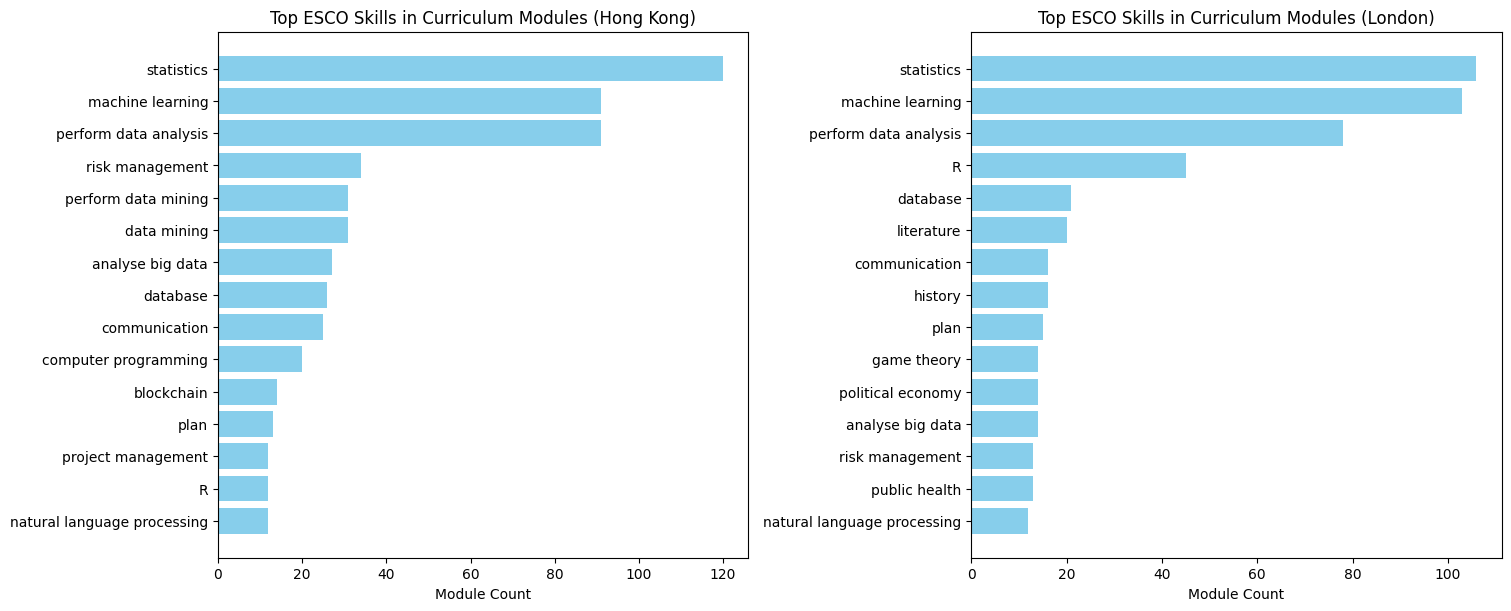

In [214]:
# Get the unique cities
cities = df["city"].unique()

# Create a 1-row, 2-column subplot grid
fig, axes = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

for i, city in enumerate(cities):
    ax = axes[i]  # Select the appropriate subplot
    top_skills = (
        city_skill_counts[city_skill_counts["city"] == city]
        .head(15)
    )

    ax.barh(top_skills["esco_skills"], top_skills["count"], color="skyblue")
    ax.set_title(f"Top ESCO Skills in Curriculum Modules ({city})")
    ax.set_xlabel("Module Count")
    ax.invert_yaxis()

# Save the combined plot
plt.savefig(output_dir / "esco_top_skills_two_cities.png")
plt.show()

## 4.7 ESCO Skill Type Distribution

This analysis compares the balance of skill types (e.g., technical vs transversal)
emphasised across curriculum modules in each city.


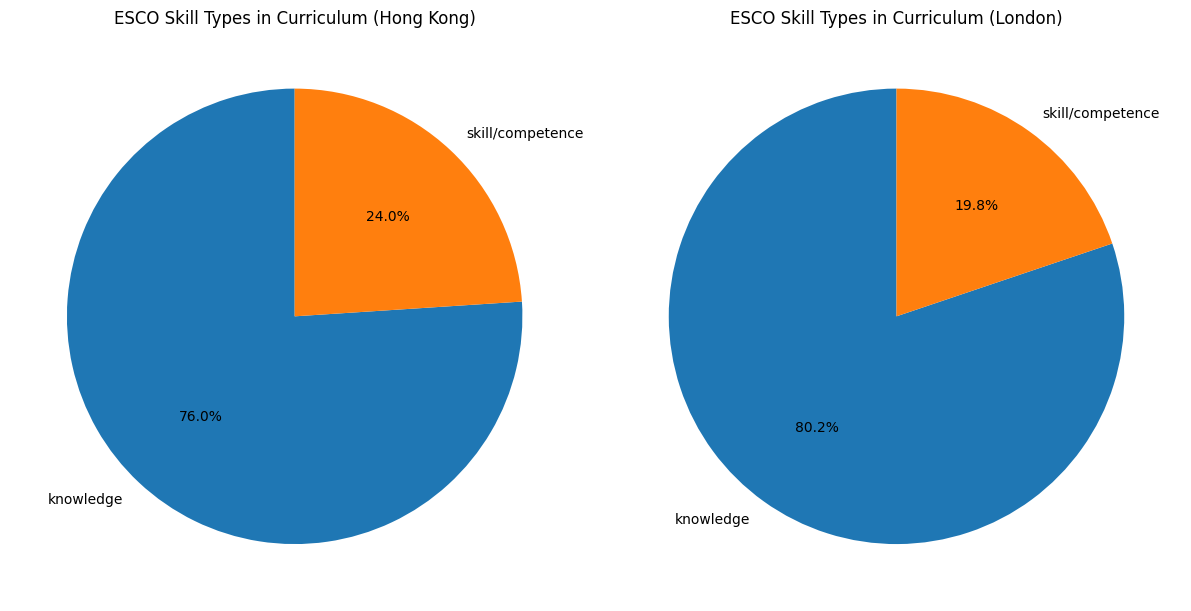

In [215]:
skill_type_counts = (
    df.explode("esco_skill_types")
      .groupby(["city", "esco_skill_types"])
      .size()
      .reset_index(name="count")
)

# Get the unique cities
cities = df["city"].unique()

# Create a subplot grid: 1 row, 2 columns for the two cities
fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

for i, city in enumerate(cities):
    ax = axes[i]  # Select the appropriate subplot
    subset = skill_type_counts[skill_type_counts["city"] == city]

    # Create the pie chart for the current city
    ax.pie(
        subset["count"],
        labels=subset["esco_skill_types"],
        autopct="%1.1f%%",
        startangle=90
    )
    ax.set_title(f"ESCO Skill Types in Curriculum ({city})")

# Save the combined figure
plt.savefig(output_dir / "esco_skill_types_two_cities.png")
plt.show()

## 4.8 Statistic tests

### Perform chi-square test, Cramér’s V

In [216]:
# Explode esco_skills
df_exploded = df.explode("esco_skills")
# Select only top 10 ESCO skills
top_skills = df_exploded["esco_skills"].value_counts().nlargest(10).index
# Filter exploded DF to top skills
df_top = df_exploded[df_exploded["esco_skills"].isin(top_skills)]
# Create contingency table: city x skill
contingency = pd.crosstab(df_top["city"], df_top["esco_skills"])

from scipy.stats import chi2_contingency
import numpy as np

chi2, p, dof, ex = chi2_contingency(contingency)
print(f"Chi2: {chi2}, p-value: {p:.4f}")

# Cramér’s V
n = contingency.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape)-1)))
print(f"Cramér's V: {cramers_v:.4f}")



Chi2: 72.11357928686837, p-value: 0.0000
Cramér's V: 0.2843


### Jensen-Shannon Divergence

In [217]:
from scipy.spatial.distance import jensenshannon

city1 = df[df["city"]=="London"].explode("esco_skills")["esco_skills"].value_counts(normalize=True)
city2 = df[df["city"]=="Hong Kong"].explode("esco_skills")["esco_skills"].value_counts(normalize=True)

# Align indices
all_skills = city1.index.union(city2.index)
p = city1.reindex(all_skills, fill_value=0)
q = city2.reindex(all_skills, fill_value=0)

jsd = jensenshannon(p, q)
print(f"Jensen-Shannon Divergence: {jsd}")


Jensen-Shannon Divergence: 0.34120282728811474


### Entropy / diversity measures

In [218]:
from scipy.stats import entropy

entropy_london = entropy(city1)
entropy_hk = entropy(city2)
print(f"Entropy (London): {entropy_london}\nEntropy (HK): {entropy_hk}")

Entropy (London): 3.7781155081808397
Entropy (HK): 3.6940555216456157


In [219]:
df.to_parquet("curriculum_with_esco.parquet", index=False)